
Running: VANILLA
Ep01 | Acc=0.0842 | TaskGrad=5.50e+09 | FinalGrad=6.00e+10 | SMax=60.05 | SMin=1.25e-01
Ep02 | Acc=0.0996 | TaskGrad=9.19e+07 | FinalGrad=1.05e+09 | SMax=60.05 | SMin=1.25e-01
Ep03 | Acc=0.1176 | TaskGrad=3.20e+07 | FinalGrad=4.06e+08 | SMax=60.05 | SMin=1.26e-01
Ep04 | Acc=0.1290 | TaskGrad=2.56e+07 | FinalGrad=3.39e+08 | SMax=60.05 | SMin=1.26e-01
Ep05 | Acc=0.1298 | TaskGrad=2.03e+07 | FinalGrad=2.67e+08 | SMax=60.05 | SMin=1.26e-01
Ep06 | Acc=0.1408 | TaskGrad=1.60e+07 | FinalGrad=2.06e+08 | SMax=60.05 | SMin=1.26e-01
Ep07 | Acc=0.1460 | TaskGrad=1.50e+07 | FinalGrad=1.96e+08 | SMax=60.05 | SMin=1.26e-01
Ep08 | Acc=0.1668 | TaskGrad=1.23e+07 | FinalGrad=1.58e+08 | SMax=60.05 | SMin=1.26e-01
Ep09 | Acc=0.1478 | TaskGrad=1.23e+07 | FinalGrad=1.61e+08 | SMax=60.05 | SMin=1.25e-01
Ep10 | Acc=0.1116 | TaskGrad=1.14e+07 | FinalGrad=1.45e+08 | SMax=60.05 | SMin=1.25e-01

Running: DCMR
Ep01 | Acc=0.1152 | TaskGrad=1.21e+09 | FinalGrad=7.55e+00 | SMax=45.60 | SMin=1.19e-01

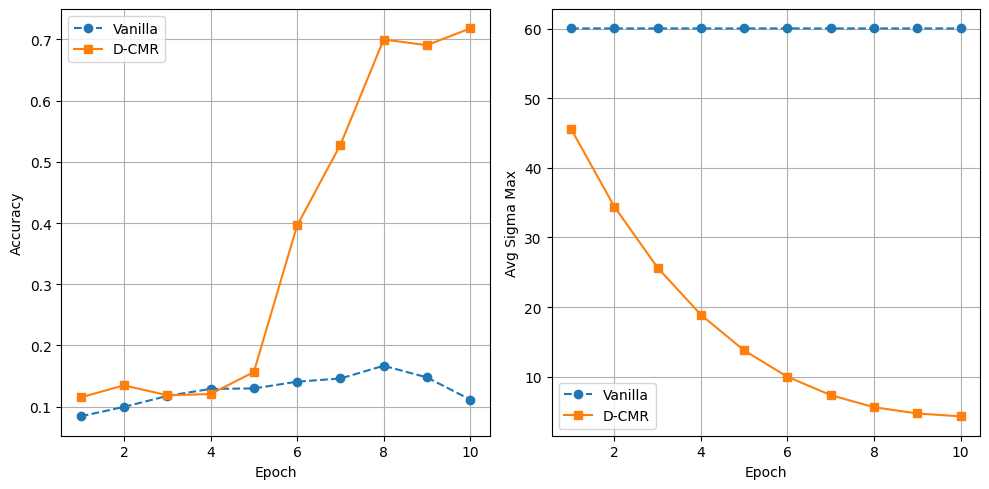

In [3]:
import os, math, random
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(s: int):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(s)
        torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

@dataclass
class Config:
    seed: int = 42
    epochs: int = 10
    batch_size: int = 128
    lr: float = 2e-3
    depth: int = 19
    width: int = 192
    explode_base: float = 2.3
    spike_amp: float = 60.0
    target_lam: float = 9.0
    poly_power: int = 4
    alpha_spec: float = 1.0
    alpha_mom: float = 0.1
    penalty_every: int = 1
    ntrain: int = 10000
    ntest: int = 5000

class DataManager:
    def __init__(self, cfg: Config):
        self.cfg = cfg
    
    def get_loaders(self):
        tfm = transforms.Compose([transforms.ToTensor()])
        train_ds = datasets.MNIST("./data", train=True, download=True, transform=tfm)
        test_ds = datasets.MNIST("./data", train=False, download=True, transform=tfm)
        
        if self.cfg.ntrain:
            idx = np.random.default_rng(self.cfg.seed).choice(len(train_ds), self.cfg.ntrain, replace=False)
            train_ds = Subset(train_ds, idx)
        if self.cfg.ntest:
            idx = np.random.default_rng(self.cfg.seed+1).choice(len(test_ds), self.cfg.ntest, replace=False)
            test_ds = Subset(test_ds, idx)
            
        gen = torch.Generator().manual_seed(self.cfg.seed)
        train_dl = DataLoader(train_ds, batch_size=self.cfg.batch_size, shuffle=True, generator=gen)
        test_dl = DataLoader(test_ds, batch_size=512, shuffle=False)
        return train_dl, test_dl

class DeepMLP(nn.Module):
    def __init__(self, depth=19, width=192):
        super().__init__()
        layers = []
        in_dim = 28 * 28
        for _ in range(depth - 1):
            layers.append(nn.Linear(in_dim, width))
            in_dim = width
        layers.append(nn.Linear(in_dim, 10))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = x * 1.1 + 0.1
                x = F.relu(x)
        return x

class Initializer:
    @staticmethod
    def apply_explosion(model: nn.Module, base: float, spike: float):
        with torch.no_grad():
            for m in model.modules():
                if isinstance(m, nn.Linear):
                    nn.init.orthogonal_(m.weight, gain=1.0)
                    m.weight.mul_(base)
                    if m.bias is not None:
                        m.bias.zero_()
                    out_d, in_d = m.weight.shape
                    u = torch.randn(out_d, device=DEVICE)
                    u /= (u.norm() + 1e-12)
                    v = torch.randn(in_d, device=DEVICE)
                    v /= (v.norm() + 1e-12)
                    m.weight.add_(spike * torch.outer(u, v))

class SpectralUtils:
    @staticmethod
    def get_extrema(W: torch.Tensor, eps=1e-6):
        G = W.t() @ W
        G = 0.5 * (G + G.t())
        try:
            evals = torch.linalg.eigvalsh(G)
            return evals[-1].clamp(min=0.0), evals[0].clamp(min=0.0)
        except:
            return SpectralUtils.power_iter(W, eps)

    @staticmethod
    def power_iter(W, eps):
        def mv(x): return W.t() @ (W @ x)
        n = W.shape[1]
        v = torch.randn(n, device=W.device)
        v /= (v.norm() + 1e-12)
        for _ in range(20):
            v = mv(v)
            v /= (v.norm() + 1e-12)
        lmax = torch.dot(v, mv(v))
        return lmax, torch.tensor(0.0, device=W.device)

    @staticmethod
    def snapshot(model: nn.Module):
        smaxs, smins = [], []
        with torch.no_grad():
            for m in model.modules():
                if isinstance(m, nn.Linear):
                    lmax, lmin = SpectralUtils.get_extrema(m.weight)
                    smaxs.append(lmax.sqrt().item())
                    smins.append(lmin.sqrt().item())
        if not smaxs: return 0.0, 0.0
        return np.mean(smaxs), np.mean(smins)

class DCMR:
    def __init__(self, target: float, power: int, alpha_spec: float, alpha_mom: float,
                 K: int = 5, beta: float = 0.15):
        self.target = target
        self.power = power
        self.alpha_spec = alpha_spec
        self.alpha_mom = alpha_mom

        self.K = int(K) 
        self.beta = float(beta) 
        ks = torch.arange(3, self.K + 1, dtype=torch.float32)
        self.w_vec = torch.exp(self.beta * (ks - 3.0)).to(DEVICE)

    def compute_loss(self, model: nn.Module):
        loss = 0.0
        for m in model.modules():
            if isinstance(m, nn.Linear):
                lmax, lmin = SpectralUtils.get_extrema(m.weight)

                ratio = lmax / self.target
                l_wall = torch.pow(ratio, self.power)
                l_log  = -torch.log(lmin + 1e-6)

                mom = self._moments_general(m.weight, lmax, lmin)
                loss += self.alpha_spec * (l_wall + l_log) + self.alpha_mom * mom
        return loss

    def _moments_general(self, W: torch.Tensor, lmax: torch.Tensor, lmin: torch.Tensor) -> torch.Tensor:

        c = 0.5 * (lmax + lmin)
        d = 0.5 * (lmax - lmin).clamp(min=1e-6)

        def mv(x: torch.Tensor) -> torch.Tensor:
            y = W @ x
            y = W.t() @ y
            return (y - c * x) / d

        n = W.shape[1]
        S = 4
        Z = torch.empty((n, S), device=DEVICE).bernoulli_().mul_(2.0).add_(-1.0)

        V_prev = Z    
        V_cur  = mv(Z)            

        s_vals = []

        for k in range(2, self.K + 1):
            V_next = 2.0 * mv(V_cur) - V_prev
            V_prev, V_cur = V_cur, V_next

            if k >= 3:
                est = (Z * V_cur).sum(dim=0).mean() / float(n)
                s_vals.append(est)

        if not s_vals:
            return torch.zeros([], device=DEVICE)

        s_vec = torch.stack(s_vals)
        w_vec = self.w_vec.to(device=DEVICE, dtype=s_vec.dtype)
        return torch.sum(w_vec * (s_vec ** 2))

class Trainer:
    def __init__(self, model: nn.Module, cfg: Config, mode: str):
        self.model = model
        self.cfg = cfg
        self.mode = mode
        self.opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
        self.dcmr = DCMR(cfg.target_lam, cfg.poly_power, cfg.alpha_spec, cfg.alpha_mom)
        self.ce = nn.CrossEntropyLoss()

    def step(self, x, y, step_idx):
        self.opt.zero_grad(set_to_none=True)
        
        logits = self.model(x)
        loss = self.ce(logits, y)
        loss.backward()
        
        g_task_norms = []
        g_task_map = {}
        for p in self.model.parameters():
            if p.grad is not None:
                g_task_norms.append(p.grad.norm().item())
                g_task_map[p] = p.grad.detach().clone()
            else:
                g_task_map[p] = None

        avg_task_norm = np.mean(g_task_norms) if g_task_norms else 0.0

        if self.mode == "dcmr" and (step_idx % self.cfg.penalty_every == 0):
            self.opt.zero_grad(set_to_none=True)
            spec_loss = self.dcmr.compute_loss(self.model)
            spec_loss.backward()
            
            for p in self.model.parameters():
                g_task = g_task_map[p]
                g_spec = p.grad
                
                if g_task is not None and g_spec is not None:
                    u_task = g_task / (g_task.norm() + 1e-12)
                    u_spec = g_spec / (g_spec.norm() + 1e-12)
                    p.grad = u_task + u_spec
                elif g_task is not None:
                    p.grad = g_task / (g_task.norm() + 1e-12)
        
        else:
            for p in self.model.parameters():
                if g_task_map[p] is not None:
                    p.grad = g_task_map[p]

        final_norm = 0.0
        for p in self.model.parameters():
            if p.grad is not None:
                final_norm += p.grad.norm().item() ** 2
        final_norm = final_norm ** 0.5
        
        self.opt.step()
        return avg_task_norm, final_norm

class Experiment:
    def __init__(self):
        self.cfg = Config()
        self.data = DataManager(self.cfg)
        self.tr_dl, self.te_dl = self.data.get_loaders()

    def run_one(self, mode: str):
        set_seed(self.cfg.seed)
        model = DeepMLP(self.cfg.depth, self.cfg.width).to(DEVICE)
        Initializer.apply_explosion(model, self.cfg.explode_base, self.cfg.spike_amp)
        trainer = Trainer(model, self.cfg, mode)
        
        history = []
        global_step = 0
        
        print(f"\nRunning: {mode.upper()}")
        for ep in range(1, self.cfg.epochs + 1):
            model.train()
            t_norms, f_norms = [], []
            
            for x, y in self.tr_dl:
                x, y = x.to(DEVICE), y.to(DEVICE)
                tn, fn = trainer.step(x, y, global_step)
                t_norms.append(tn)
                f_norms.append(fn)
                global_step += 1
                
            model.eval()
            corr, tot = 0, 0
            with torch.no_grad():
                for x, y in self.te_dl:
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    out = model(x)
                    corr += (out.argmax(1) == y).sum().item()
                    tot += y.size(0)
            acc = corr / tot
            
            smax, smin = SpectralUtils.snapshot(model)
            
            avg_tn = np.mean(t_norms)
            avg_fn = np.mean(f_norms)
            
            print(f"Ep{ep:02d} | Acc={acc:.4f} | TaskGrad={avg_tn:.2e} | FinalGrad={avg_fn:.2e} | SMax={smax:.2f} | SMin={smin:.2e}")
            history.append({"epoch": ep, "acc": acc, "smax": smax})
            
        return pd.DataFrame(history)

    def execute(self):
        res_vanilla = self.run_one("vanilla")
        res_dcmr = self.run_one("dcmr")
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(res_vanilla["epoch"], res_vanilla["acc"], "o--", label="Vanilla")
        plt.plot(res_dcmr["epoch"], res_dcmr["acc"], "s-", label="D-CMR")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(res_vanilla["epoch"], res_vanilla["smax"], "o--", label="Vanilla")
        plt.plot(res_dcmr["epoch"], res_dcmr["smax"], "s-", label="D-CMR")
        plt.xlabel("Epoch"); plt.ylabel("Avg Sigma Max"); plt.legend(); plt.grid(True)
        
        plt.tight_layout()
        plt.savefig("dcmr_vs_vanilla.png")
        print("\nDone. Saved dcmr_vs_vanilla.png")

if __name__ == "__main__":
    exp = Experiment()
    exp.execute()